Convertion from CellRank pipeline
=================================

## Reproduction of CellRank notebook

Here we run a compresserd version of the CellRank basics notebook, without the plots.

In [1]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo')
cr.settings.verbosity = 2

In [2]:
import warnings
warnings.simplefilter("ignore", category = UserWarning)
warnings.simplefilter("ignore", category = FutureWarning)
warnings.simplefilter("ignore", category = DeprecationWarning)

In [3]:
adata = cr.datasets.pancreas()
adata.raw = adata # We want to keep all the genes for testing on the resulting tree 
scv.pp.filter_genes(adata,min_shared_counts=20)
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
scv.tl.recover_dynamics(adata, n_jobs=20)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)
cr.tl.terminal_states(adata, cluster_key='clusters', weight_connectivities=0.2)
cr.tl.lineages(adata)
scv.tl.recover_latent_time(adata)

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 20/88 cores)


  0%|          | 0/1078 [00:00<?, ?gene/s]

    finished (0:00:28) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph


Computing transition matrix based on logits using `'deterministic'` mode


    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Estimating `softmax_scale` using `'deterministic'` mode


  0%|          | 0/2531 [00:00<?, ?cell/s]

Setting `softmax_scale=3.7951`


  0%|          | 0/2531 [00:00<?, ?cell/s]

    Finish (0:00:04)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing eigendecomposition of the transition matrix
Adding `adata.uns['eig_fwd']`
       `.eigendecomposition`
    Finish (0:00:00)
Computing Schur decomposition
Adding `adata.uns['eig_fwd']`
       `.eigendecomposition`
       `.schur`
       `.schur_matrix`
    Finish (0:00:11)
Computing `3` macrostates
Adding `.macrostates_memberships`
       `.macrostates`
       `.schur`
       `.coarse_T`
       `.coarse_stationary_distribution`
    Finish (0:00:00)
Adding `adata.obs['terminal_states_probs']`
       `adata.obs['terminal_states']`
       `adata.obsm['macrostates_fwd']`
       `.terminal_states_probabilities`
       `.terminal_states`
    Finish
Computing lineage probabilities towards terminal states
Computing absorption probabilities
Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


## Plotting the information that will be used for conversion

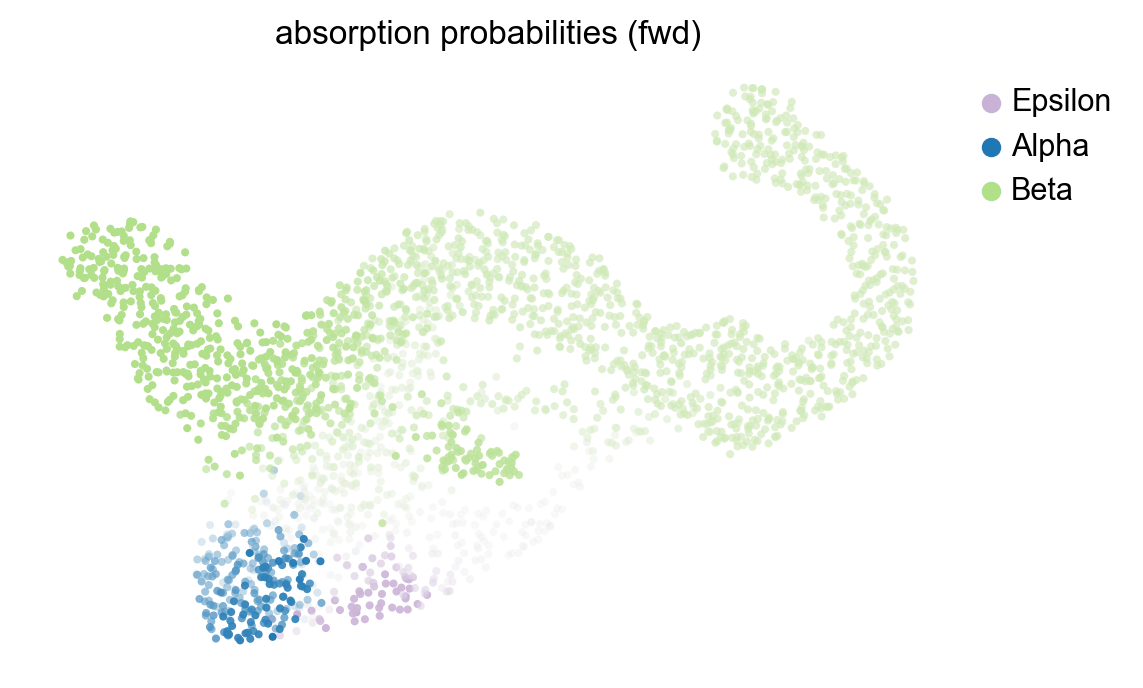

In [4]:
cr.pl.lineages(adata)

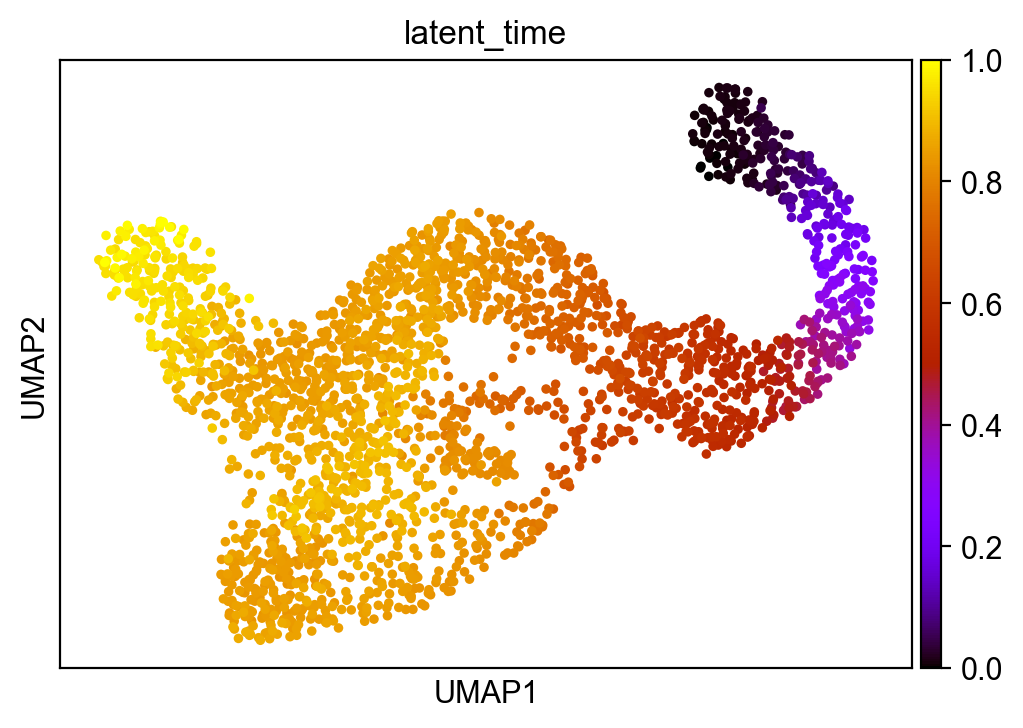

In [7]:
sc.pl.umap(adata,color="latent_time",cmap="gnuplot")

## Converting CellRank results to a scFates principal tree

In [10]:
import scFates as scf

In [11]:
scf.tl.cellrank_to_tree(adata,time="latent_time",Nodes=300,seed=1,reassign_pseudotime=False)

Solving TSP for `3` states


Converting CellRank results to a principal tree --> with .obsm['X_fates'], created by combining:
    .obsm['X_fate_simplex_fwd'] (from cr.pl.circular_projection) and adata.obs['latent_time']

inferring a principal tree --> parameters used 
    300 principal points, sigma = 0.1, lambda = 20, metric = euclidean
    fitting:  92%|█████████▏| 46/50 [00:04<00:00, 10.84it/s]
    converged
    finished (0:00:04) --> added 
    .uns['ppt'], dictionnary containing inferred tree.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['R'] soft assignment of cells to principal point in representation space.
    .uns['graph']['F'] coordinates of principal points in representation space.

auto selecting a root using latent_time.

root selected --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
projecting cells onto the principal

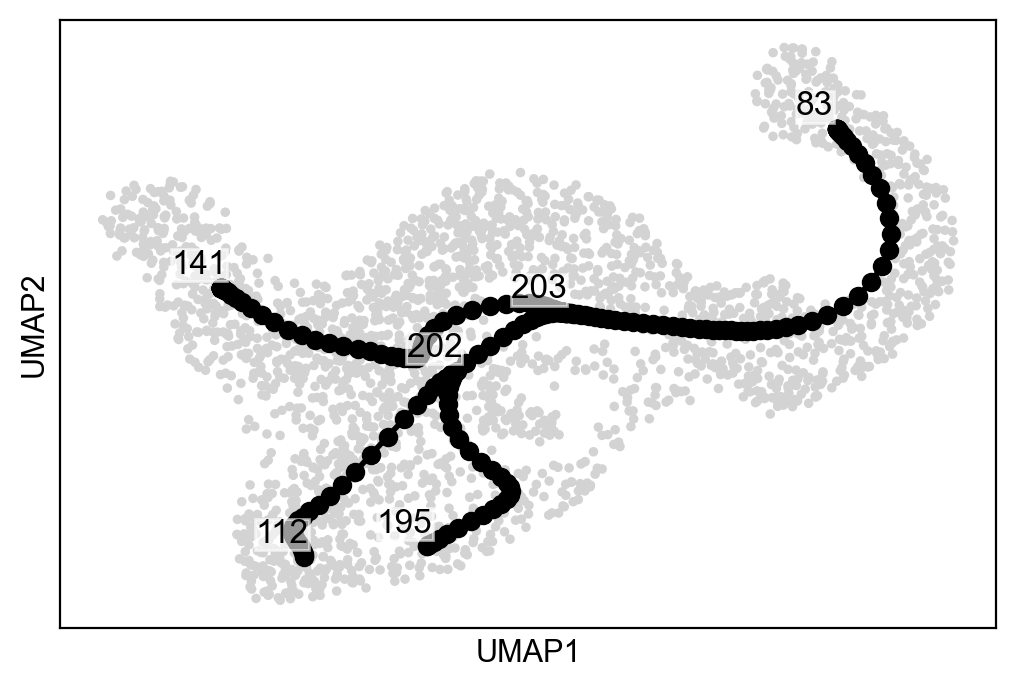

In [12]:
scf.pl.graph(adata)

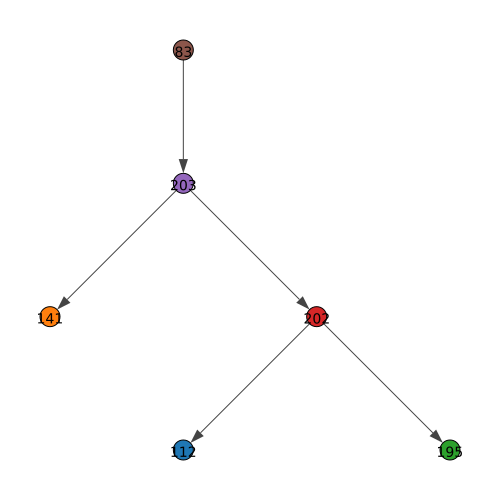

In [13]:
scf.pl.milestones(adata)

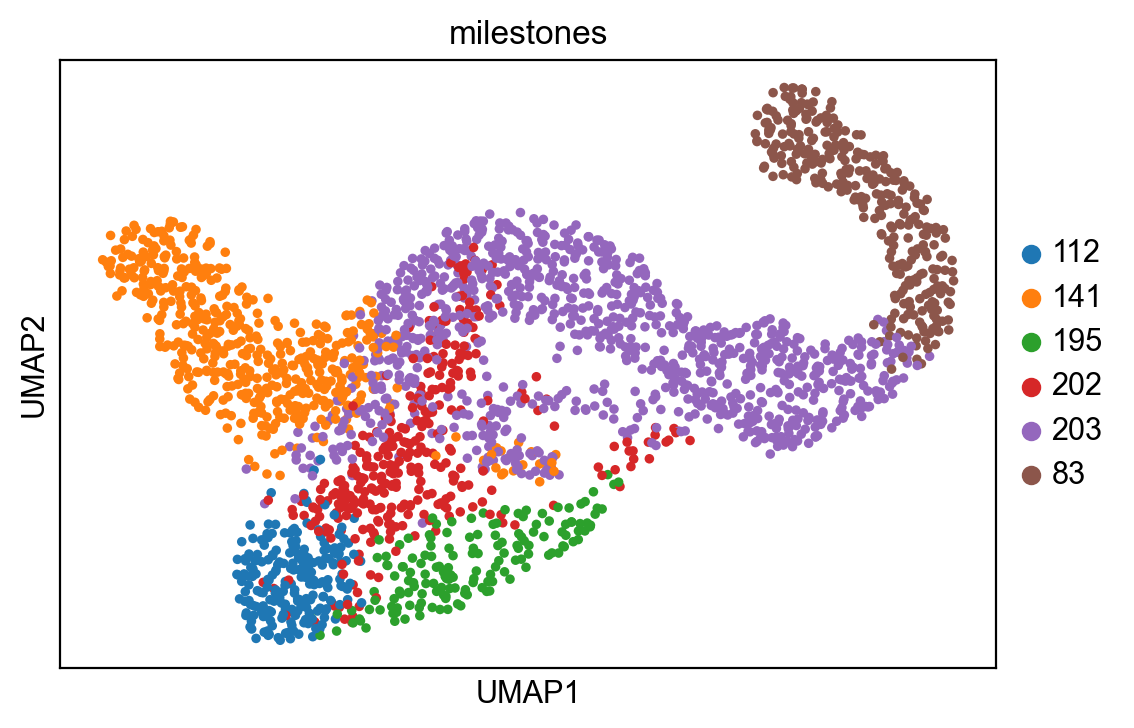

In [14]:
sc.pl.umap(adata,color=["milestones"])

In [15]:
scf.tl.rename_milestones(adata,['Alpha','Beta','Epsilon','alpha_vs_epsilon','beta_vs_rest','Progenitors'])

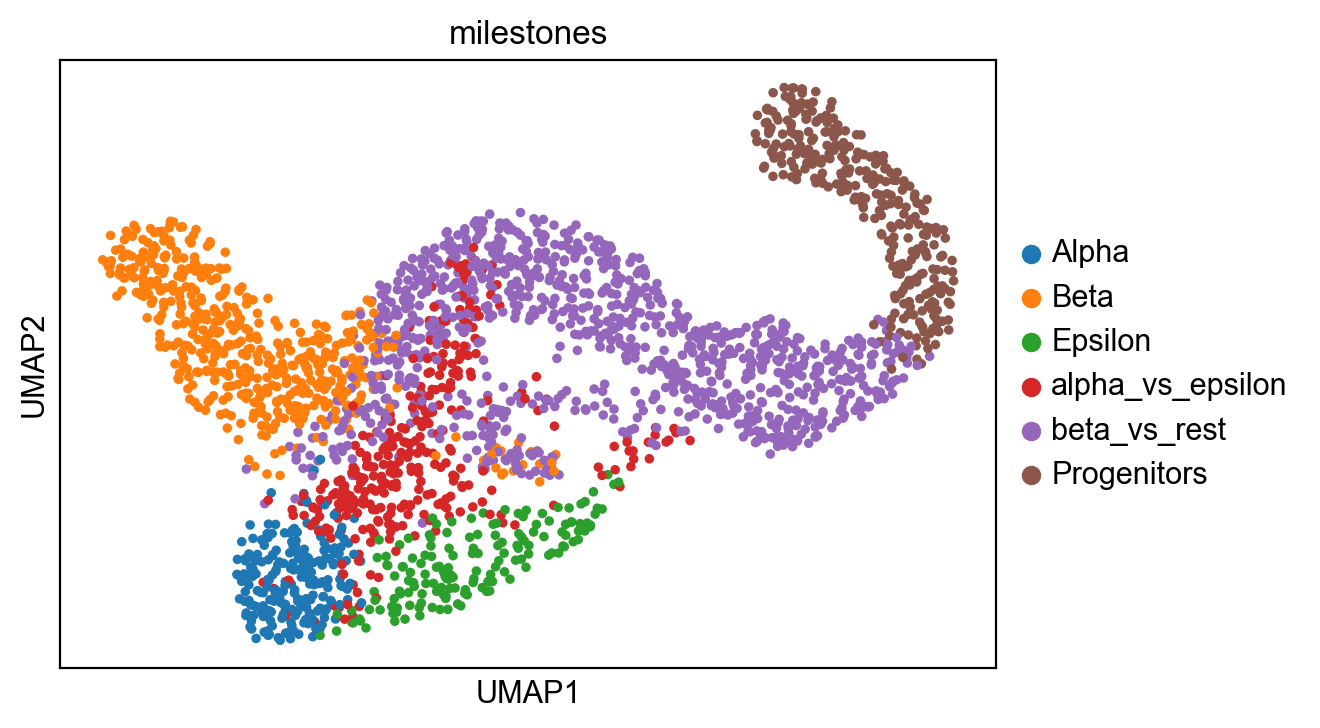

In [16]:
sc.pl.umap(adata,color=["milestones"])

In [17]:
adata=adata.raw.to_adata()

In [18]:
sc.pp.filter_genes(adata,min_cells=3)
sc.pp.normalize_total(adata,target_sum=1e6)
sc.pp.log1p(adata,base=10)

In [19]:
scf.tl.test_association(adata,n_jobs=40)

test features for association with the trajectory
    single mapping : 100%|██████████| 14939/14939 [01:42<00:00, 146.39it/s]
    found 1301 significant features (0:01:43) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


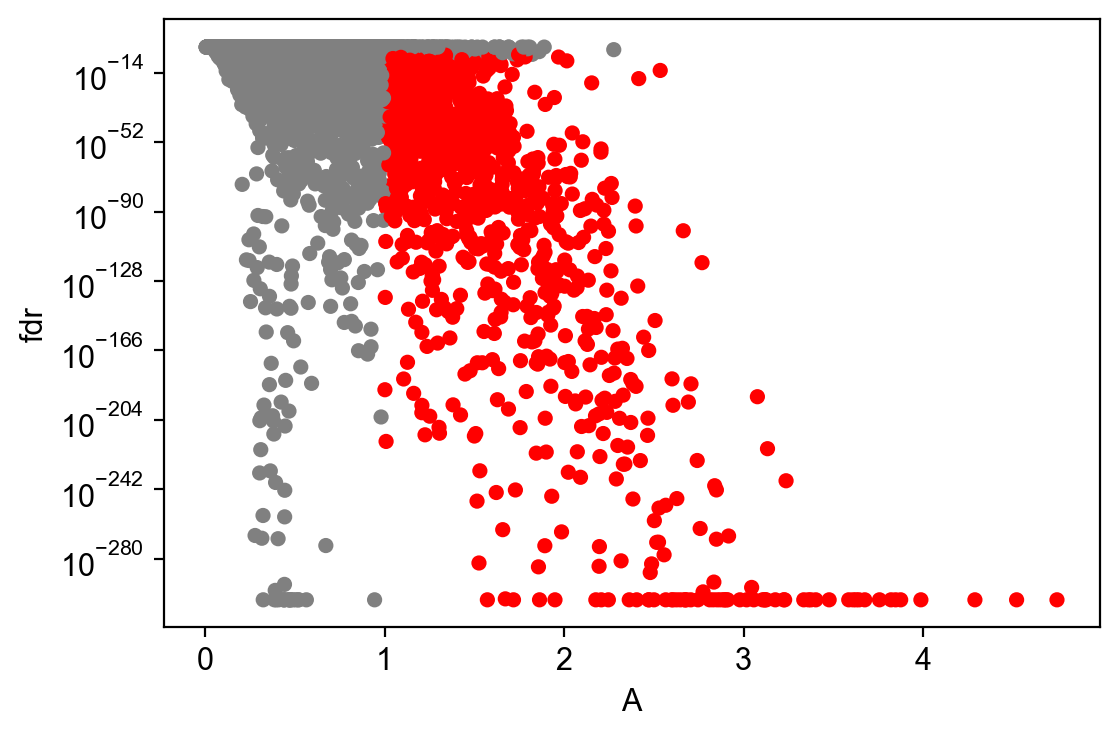

In [20]:
scf.pl.test_association(adata)

In [21]:
scf.tl.fit(adata,n_jobs=40)

fit features associated with the trajectory
    single mapping : 100%|██████████| 1301/1301 [00:18<00:00, 70.55it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:21) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


In [22]:
root='Progenitors'
miles=['Alpha','Epsilon','Beta']

In [23]:
scf.tl.test_fork(adata,root_milestone=root,milestones=miles,n_jobs=20,rescale=True)

testing fork
    single mapping
    differential expression: 100%|██████████| 1301/1301 [00:31<00:00, 41.28it/s]
    test for upregulation for each leave vs root
    leave Beta: 100%|██████████| 429/429 [00:00<00:00, 2127.34it/s]
    finished (0:00:34) --> added 
    .uns['Progenitors->Alpha<>Epsilon<>Beta']['fork'], DataFrame with fork test results.


In [24]:
scf.tl.branch_specific(adata,root_milestone=root,milestones=miles,effect=.05)

    branch specific features: Epsilon: 65, Alpha: 58, Beta: 11
    finished --> updated 
    .uns['Progenitors->Alpha<>Epsilon<>Beta']['fork'], DataFrame updated with additionnal 'branch' column.


In [25]:
scf.tl.activation(adata,root_milestone=root,milestones=miles,n_jobs=20,pseudotime_offset=0.1)

testing activation
    leave Beta: 100%|██████████| 11/11 [00:00<00:00, 9544.34it/s]
    threshold pseudotime is: 0.5763419899313084
    16 early and 42 late features specific to leave Alpha
    25 early and 40 late features specific to leave Epsilon
    8 early and 3 late features specific to leave Beta
    finished (0:00:02) --> updated 
    .uns['Progenitors->Alpha<>Epsilon<>Beta']['fork'], DataFrame updated with additionnal 'activation' and 'module' columns.


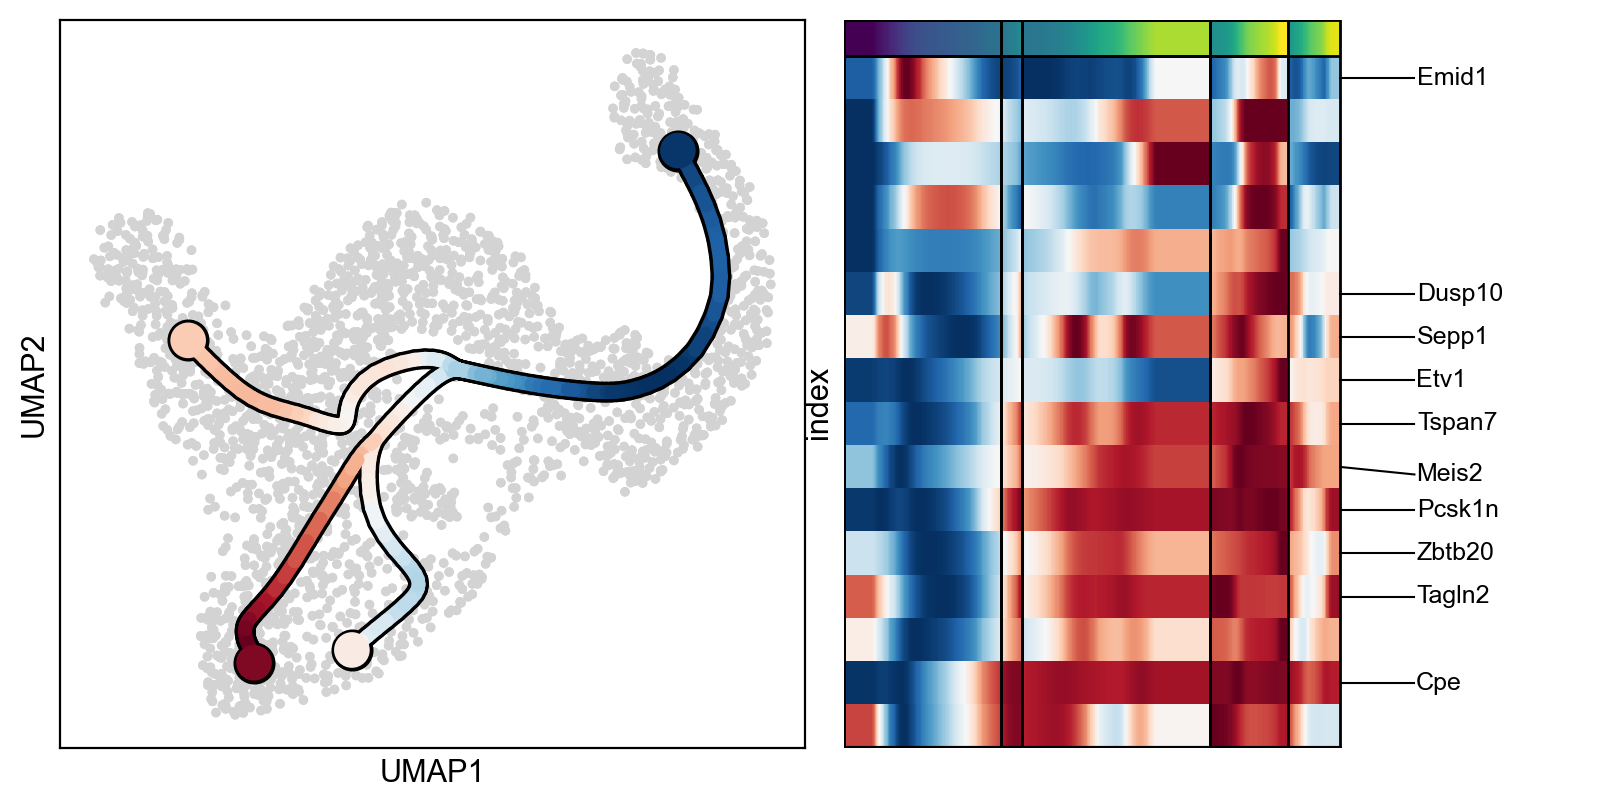

In [26]:
scf.pl.trends(adata,root_milestone=root,milestones=miles,branch="Alpha",module="early")

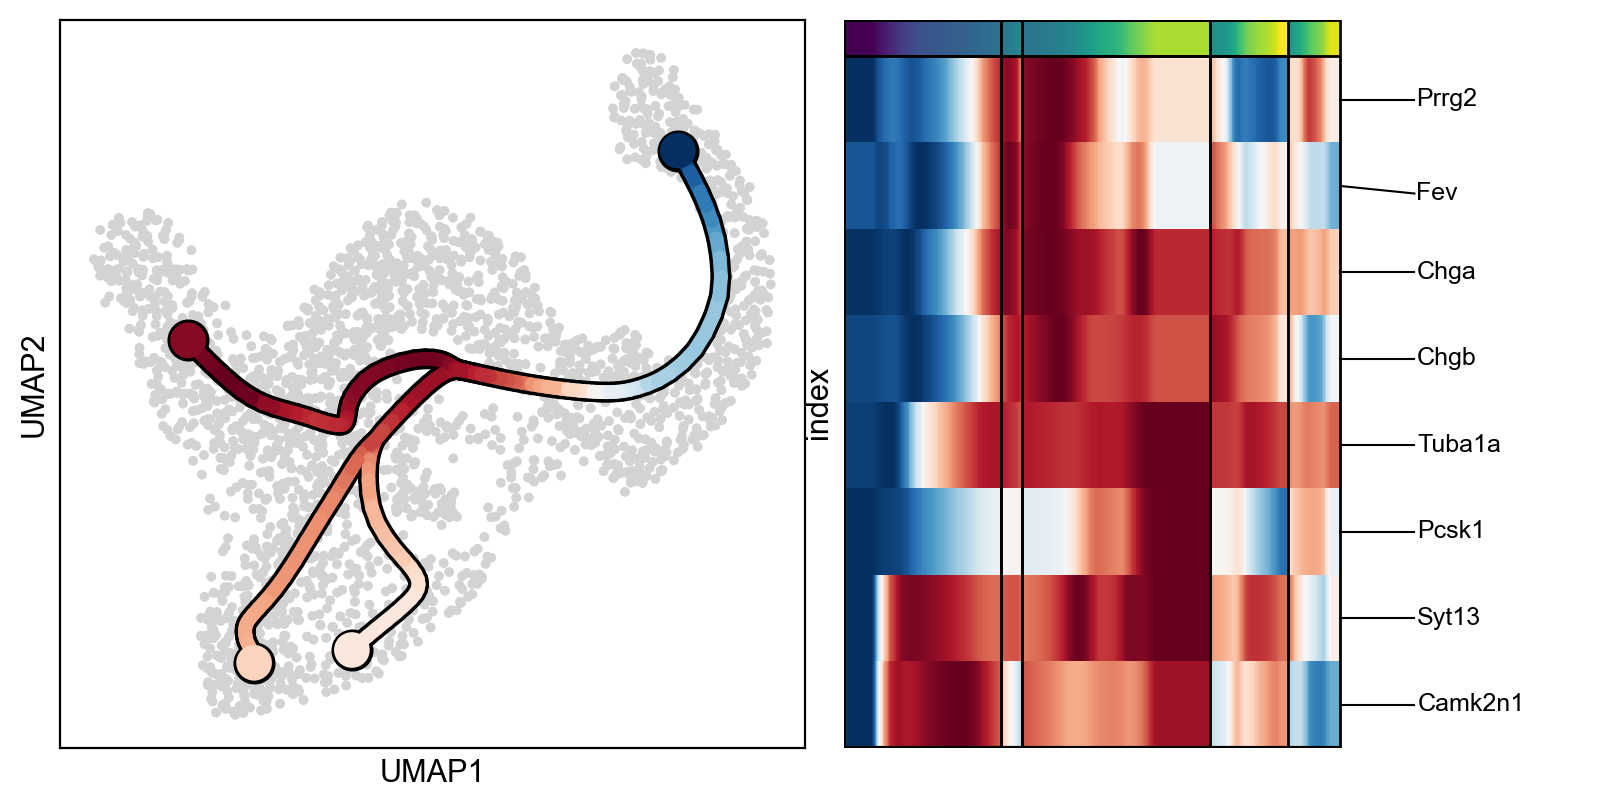

In [27]:
scf.pl.trends(adata,root_milestone=root,milestones=miles,branch="Beta",module="early")

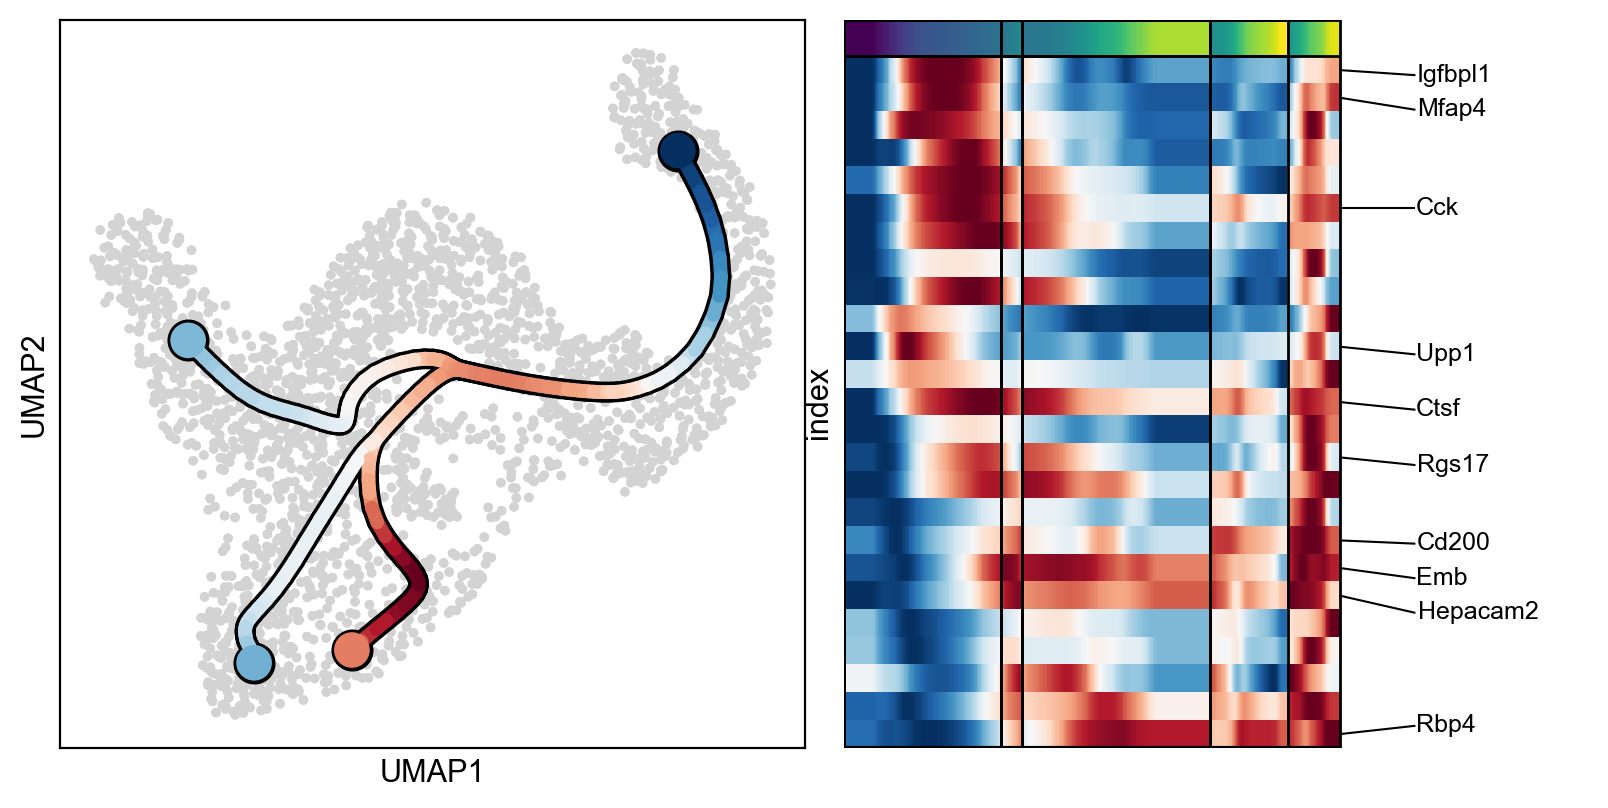

In [28]:
scf.pl.trends(adata,root_milestone=root,milestones=miles,branch="Epsilon",module="early")